# Предсказание калорийности блюд

Этот ноутбук содержит:
1. EDA (Исследовательский анализ данных)
2. Обучение модели
3. Валидация качества

## Цель проекта
Создать модель глубокого обучения для предсказания калорийности блюд по фотографии и списку ингредиентов.

## Целевая метрика
MAE < 50 на тестовой выборке


In [ ]:
# Импорт необходимых библиотек
import sys
sys.path.append('.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Настройка стиля для графиков
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Импорт наших модулей
from scripts.dataset import CalorieDataset, get_default_transforms, load_data
from scripts.model import create_model
from scripts.utils import set_seed, train, compute_metrics, validate_epoch

print("Библиотеки успешно импортированы!")


Библиотеки успешно импортированы!


## Часть 1: EDA (Исследовательский анализ данных)


In [ ]:
# Загрузка данных
print("Загрузка данных...")
dish_df, ingredients_df = load_data(data_dir='nutrition/data')

print(f"\nРазмер датасета dishes: {dish_df.shape}")
print(f"Размер датасета ingredients: {ingredients_df.shape}")

print("\nПервые строки dish.csv:")
print(dish_df.head())


Загрузка данных...

Размер датасета dishes: (3262, 5)
Размер датасета ingredients: (555, 2)

Первые строки dish.csv:
           dish_id  total_calories  total_mass  \
0  dish_1561662216      300.794281       193.0   
1  dish_1561662054      419.438782       292.0   
2  dish_1562008979      382.936646       290.0   
3  dish_1560455030       20.590000       103.0   
4  dish_1558372433       74.360001       143.0   

                                         ingredients  split  
0  ingr_0000000508;ingr_0000000122;ingr_000000002...   test  
1  ingr_0000000312;ingr_0000000026;ingr_000000002...  train  
2  ingr_0000000448;ingr_0000000520;ingr_000000046...   test  
3    ingr_0000000471;ingr_0000000031;ingr_0000000347  train  
4                                    ingr_0000000453  train  


In [ ]:
# Базовая статистика
print("Статистика калорийности:")
print(dish_df['total_calories'].describe())

print("\nСтатистика массы:")
print(dish_df['total_mass'].describe())

print("\nРазделение данных:")
print(dish_df['split'].value_counts())


Статистика калорийности:
count    3262.000000
mean      255.012738
std       219.637570
min         0.000000
25%        80.114996
50%       209.110062
75%       375.122963
max      3943.325195
Name: total_calories, dtype: float64

Статистика массы:
count    3262.000000
mean      214.980074
std       161.497428
min         1.000000
25%        92.000000
50%       177.000000
75%       305.000000
max      3051.000000
Name: total_mass, dtype: float64

Разделение данных:
split
train    2755
test      507
Name: count, dtype: int64


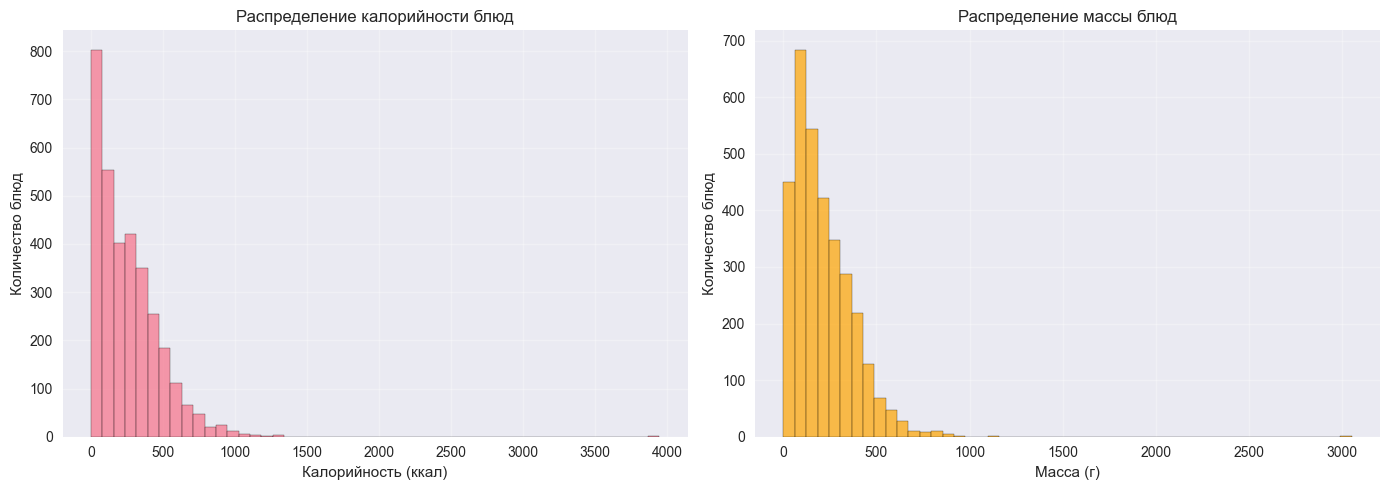


Корреляция между массой и калорийностью: 0.760


In [ ]:
# Визуализация распределения калорийности
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Распределение калорийности
axes[0].hist(dish_df['total_calories'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Калорийность (ккал)')
axes[0].set_ylabel('Количество блюд')
axes[0].set_title('Распределение калорийности блюд')
axes[0].grid(True, alpha=0.3)

# Распределение массы
axes[1].hist(dish_df['total_mass'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_xlabel('Масса (г)')
axes[1].set_ylabel('Количество блюд')
axes[1].set_title('Распределение массы блюд')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Корреляция между массой и калорийностью
correlation = dish_df['total_calories'].corr(dish_df['total_mass'])
print(f"\nКорреляция между массой и калорийностью: {correlation:.3f}")


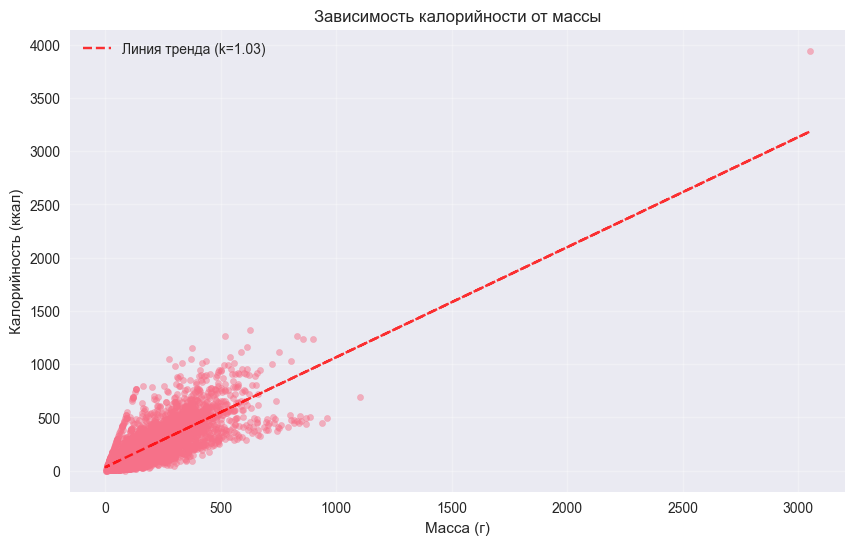

In [ ]:
# Визуализация зависимости калорийности от массы
plt.figure(figsize=(10, 6))
plt.scatter(dish_df['total_mass'], dish_df['total_calories'], alpha=0.5, s=20)
plt.xlabel('Масса (г)')
plt.ylabel('Калорийность (ккал)')
plt.title('Зависимость калорийности от массы')
plt.grid(True, alpha=0.3)

# Добавление линии тренда
z = np.polyfit(dish_df['total_mass'], dish_df['total_calories'], 1)
p = np.poly1d(z)
plt.plot(dish_df['total_mass'], p(dish_df['total_mass']), "r--", alpha=0.8, label=f'Линия тренда (k={z[0]:.2f})')
plt.legend()
plt.show()


Статистика по количеству ингредиентов:
count    3262.000000
mean        7.313305
std         6.943276
min         1.000000
25%         1.000000
50%         4.000000
75%        12.000000
max        34.000000
Name: num_ingredients, dtype: float64


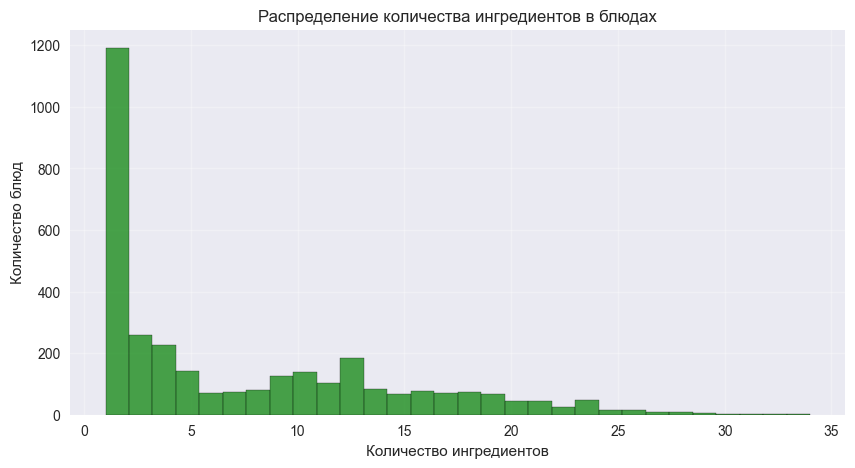

In [ ]:
# Анализ количества ингредиентов
dish_df['num_ingredients'] = dish_df['ingredients'].apply(lambda x: len(x.split(';')))

print("Статистика по количеству ингредиентов:")
print(dish_df['num_ingredients'].describe())

plt.figure(figsize=(10, 5))
plt.hist(dish_df['num_ingredients'], bins=30, edgecolor='black', alpha=0.7, color='green')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Количество блюд')
plt.title('Распределение количества ингредиентов в блюдах')
plt.grid(True, alpha=0.3)
plt.show()


Примеры блюд из датасета:


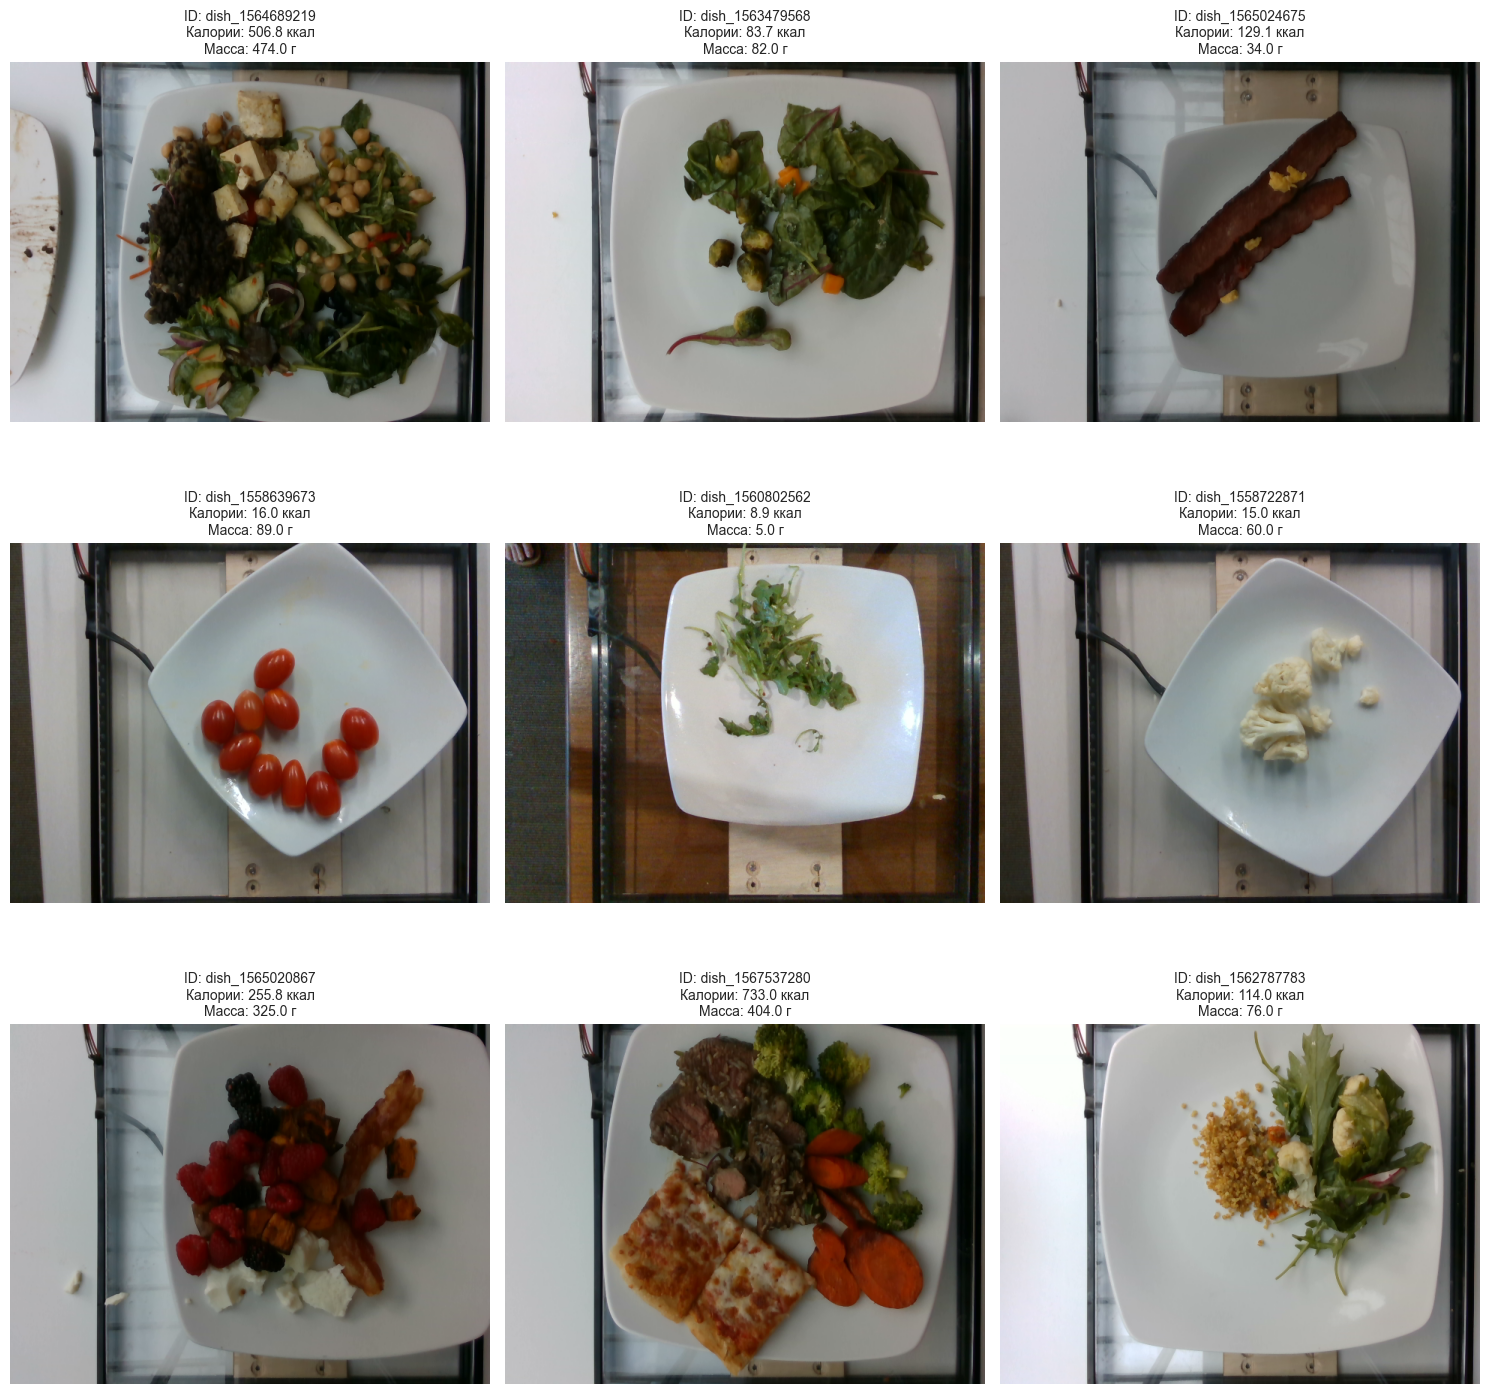

In [ ]:
# Визуализация примеров изображений
import os

def visualize_samples(dish_df, num_samples=9):
    """Визуализировать примеры блюд"""
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    sample_indices = np.random.choice(len(dish_df), num_samples, replace=False)
    
    for idx, ax in enumerate(axes):
        row = dish_df.iloc[sample_indices[idx]]
        dish_id = row['dish_id']
        image_path = f'nutrition/data/images/{dish_id}/rgb.png'
        
        if os.path.exists(image_path):
            img = Image.open(image_path)
            ax.imshow(img)
            ax.set_title(f"ID: {dish_id}\nКалории: {row['total_calories']:.1f} ккал\nМасса: {row['total_mass']} г", 
                        fontsize=10)
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Визуализация примеров
print("Примеры блюд из датасета:")
visualize_samples(dish_df)


### Выводы по EDA:

1. **Распределение калорийности**: Калорийность сильно варьируется от низких значений (около 20 ккал) до высоких (более 1100 ккал)
2. **Корреляция с массой**: Наблюдается положительная корреляция между массой и калорийностью блюда
3. **Количество ингредиентов**: Блюда содержат от 1 до 26 ингредиентов
4. **Подход**: Будем использовать мультимодальную модель, сочетающую визуальные признаки и структурированные данные


## Часть 2: Обучение модели


In [ ]:
# Обучение модели
set_seed(42)
print("Начало обучения модели...")

results = train(config_path='config.yaml')


Начало обучения модели...
Используется устройство: cuda

Загрузка данных...
Создание датасетов...
Размер обучающей выборки: 2755
Размер тестовой выборки: 507
Количество уникальных ингредиентов: 30

Создание модели...
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\po6wi/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
# Визуализация истории обучения
train_history = results['train_history']
val_history = results['val_history']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(train_history) + 1)

# График потерь
axes[0].plot(epochs, [h['loss'] for h in train_history], 'b-', label='Train Loss', linewidth=2)
axes[0].plot(epochs, [h['loss'] for h in val_history], 'r-', label='Val Loss', linewidth=2)
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss')
axes[0].set_title('График потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График MAE
axes[1].plot(epochs, [h['MAE'] for h in train_history], 'b-', label='Train MAE', linewidth=2)
axes[1].plot(epochs, [h['MAE'] for h in val_history], 'r-', label='Val MAE', linewidth=2)
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('MAE')
axes[1].set_title('График MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Лучший MAE на валидации: {results['best_val_mae']:.4f}")


## Часть 3: Валидация качества


In [ ]:
# Загрузка лучшей модели и инференс на тестовой выборке
import yaml

with open('config.yaml', 'r', encoding='utf-8') as f:
    config = yaml.safe_load(f)

test_transform = get_default_transforms(config['data']['image_size'], is_train=False)
test_dataset = CalorieDataset(dish_df, ingredients_df, images_dir=config['data']['images_dir'], split='test', transform=test_transform, max_ingredients=config['data']['max_ingredients'])
test_loader = DataLoader(test_dataset, batch_size=config['training']['batch_size'], shuffle=False, num_workers=config['training']['num_workers'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = create_model(num_ingredients=test_dataset.num_ingredients, max_ingredients=config['data']['max_ingredients'], image_embedding_dim=config['model']['image_embedding_dim'], ingredient_embedding_dim=config['model']['ingredient_embedding_dim'], hidden_dims=tuple(config['model']['hidden_dims']), dropout=config['model']['dropout'])
model.load_state_dict(torch.load(config['training']['model_save_path'], map_location=device))
model = model.to(device)
model.eval()

print("Модель загружена и готова к инференсу")


In [ ]:
# Вычисление финальных метрик на тестовой выборке
criterion = nn.L1Loss()
test_metrics = validate_epoch(model, test_loader, criterion, device)

print("=" * 60)
print("ФИНАЛЬНЫЕ МЕТРИКИ НА ТЕСТОВОЙ ВЫБОРКЕ:")
print("=" * 60)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")
print("=" * 60)

In [ ]:
# Инференс и анализ топ-5 блюд
model.eval()
all_predictions, all_targets, all_indices = [], [], []

with torch.no_grad():
    for batch_idx, (images, ingredients, masses, calories) in enumerate(test_loader):
        images = images.to(device)
        ingredients = ingredients.to(device)
        masses = masses.to(device)
        outputs = model(images, ingredients, masses).squeeze()
        all_predictions.extend(outputs.cpu().numpy())
        all_targets.extend(calories.numpy())
        all_indices.extend(range(batch_idx * len(calories), (batch_idx + 1) * len(calories)))

all_predictions, all_targets, all_indices = np.array(all_predictions), np.array(all_targets), np.array(all_indices)
errors = np.abs(all_predictions - all_targets)
top_5_worst_idx = np.argsort(errors)[-5:][::-1]

print("\nТоп-5 блюд с наибольшей ошибкой предсказания:")
print("-" * 80)


In [ ]:
# Визуализация топ-5 блюд
fig, axes = plt.subplots(1, 5, figsize=(20, 4))

for i, worst_idx in enumerate(top_5_worst_idx):
    dataset_idx = all_indices[worst_idx]
    row = test_dataset.dish_df.iloc[dataset_idx]
    dish_id = row['dish_id']
    image_path = f'nutrition/data/images/{dish_id}/rgb.png'
    img = Image.open(image_path)
    axes[i].imshow(img)
    pred, target, error = all_predictions[worst_idx], all_targets[worst_idx], errors[worst_idx]
    axes[i].set_title(f"Ошибка: {error:.1f} ккал\nПредсказано: {pred:.1f} ккал\nРеально: {target:.1f} ккал", fontsize=9)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

print("\nВозможные причины высокой ошибки:")
print("1. Сложные блюда с множеством слоев")
print("2. Скрытые ингредиенты (соусы, специи)")
print("3. Нестандартные размеры порций")
print("4. Высокая вариативность в способах приготовления")
